## Grupo 7

Integrantes:

- Fredys Alberto Simanca Herrera
- Julio Emanuel Suriano Bryk
- Fernando Javier Vera Pérez
- José Fernández López

Dataset seleccionado:

- [Yoga Posture Dataset](https://www.kaggle.com/datasets/tr1gg3rtrash/yoga-posture-dataset/data)

El trabajo se encuentra dividido en 4 partes:

1. Etapas pre-entrenado de los modelos: se realiza la carga del Dataset y todo lo relacionado a preparar la data antes del entrenamiento.
2. Estrategia 1 - Entrenado de un modelo desde cero: entramiento de una red desde cero.
3. Estrategia 2 - Red pre-entrenada: entranimiento de las redes VGG16 y EfficientNetB1 en la modalidad _transfer learning_ y _fine-tuning_.
4. Analisis y conclusiones: se justifica empíricamente las decisiones tomadas para cada uno de los modelos entrenados y se realizan las comparaciones pertinentes.


## Pre-entrenado de los modelos


### 0. Setup inicial


In [5]:
# Imports
import numpy as np
import pandas as pd

import json
import random
from pathlib import Path

import os
from PIL import Image

import tensorflow as tf
from tensorflow import keras as K

import matplotlib.pyplot as plt

# plotting style
plt.style.use("ggplot")

In [3]:
# Config del Dataset
DS_PATH = "./ds"
DS_ENTRY = f"{DS_PATH}/Poses.json"

# Config general
RANDOM_SEED = 42

# Config para imágenes
CHANNELS = 3
IMG_RES = 128
IMG_COUNT_PER_CLASS = 200
VALID_IMG_EXT = [".jpg", ".jpeg", ".png", ".bmp"]

### 1. Carga del Dataset


In [4]:
# Download if folder was not present
if not os.path.exists(DS_PATH):
    os.system(
        f"kaggle datasets download -d tr1gg3rtrash/yoga-posture-dataset -p {DS_PATH} --unzip"
    )

with open(DS_ENTRY, "r") as file:
    data = json.load(file)

df = pd.DataFrame(data["Poses"])

df.head()

,id,sanskrit_name,english_name,img_url
0,1,Navasana,Boat,https://www.dropbox.com/s/4m64ztxkj8a4dab/boat...
1,2,Ardha Navasana,Half-Boat,https://www.dropbox.com/s/1nx0r94msxjwvyp/boat...
2,3,Dhanurasana,Bow,https://www.dropbox.com/s/wizj5kwxvez4c0a/bow....
3,4,Setu Bandha Sarvangasana,Bridge,https://www.dropbox.com/s/f1w64ybg4sn8ejt/brid...
4,5,Baddha Konasana,Butterfly,https://www.dropbox.com/s/3h2pts6xbn28dh7/butt...


In [7]:
# Función para transformar imagenes de manera que las dimensiones sean iguales
def resize_and_pad_image(image, img_size):
    # En caso de que la imagen sea transparente, se agrega el fondo blanco a la imagen
    if image.mode in ("RGBA", "LA"):
        white_background = Image.new("RGB", image.size, (255, 255, 255))
        white_background.paste(image, (0, 0), mask=image)
        image = white_background

    original_width, original_height = image.size
    # Obtiene la relación de aspecto de la imagen
    aspect_ratio = original_width / original_height

    if original_width > original_height:
        new_width = img_size[0]
        new_height = int(img_size[0] / aspect_ratio)
    else:
        new_height = img_size[1]
        new_width = int(img_size[1] * aspect_ratio)

    # Aplicar escalado de la imagen
    resized_image = image.resize((new_width, new_height), Image.LANCZOS)

    # Crea una nueva imagen con la resolución deseada
    padded_image = Image.new("RGB", img_size, (255, 255, 255))

    x_offset = (img_size[0] - resized_image.size[0]) // 2
    y_offset = (img_size[1] - resized_image.size[1]) // 2

    # Pega la imagen escalada de forma tal que la relacion de aspecto de la imagen original no se altero
    padded_image.paste(resized_image, (x_offset, y_offset))

    return padded_image

In [8]:
X = []
y = []

# Objeto con id de la pose como key y el target como value
labelNames = {}

print("[INFO]: Leyendo imagenes de poses")
for id, pose in enumerate(df.itertuples()):
    print(f"[INFO]: Procesando pose: {pose.sanskrit_name} / {pose.english_name}")
    labelNames[id] = pose.english_name

    # Obtengo la carpeta de imagenes de la pose
    folder = f"{DS_PATH}/{pose.sanskrit_name}"

    # Recorremos las imagenes de cada carpeta
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)

        if Path(img_path).suffix.lower() not in VALID_IMG_EXT:
            print(f"[WARN]: Formato {img_path} no válido")
            continue

        # Carga de la imagen
        img = Image.open(img_path)

        # Aplica transformación a la imagen cargada
        img = resize_and_pad_image(img, (IMG_RES, IMG_RES))

        # Guardar imagen transformada con su label
        X.append(img)
        y.append(id)


# Convertir a numpy array
X = np.array(X)
y = np.array(y)

[INFO]: Leyendo imagenes de poses
[INFO]: Procesando pose: Navasana / Boat
[INFO]: Procesando pose: Ardha Navasana / Half-Boat
[INFO]: Procesando pose: Dhanurasana / Bow
[INFO]: Procesando pose: Setu Bandha Sarvangasana / Bridge
[INFO]: Procesando pose: Baddha Konasana / Butterfly
[INFO]: Procesando pose: Ustrasana / Camel
[INFO]: Procesando pose: Marjaryasana / Cat
[INFO]: Procesando pose: Bitilasana / Cow
[INFO]: Procesando pose: Utkatasana / Chair
[INFO]: Procesando pose: Balasana / Child's Pose


/Users/emanuel.suriano/Git/deep-learning-group-7/env/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[INFO]: Procesando pose: Sivasana / Corpse
[INFO]: Procesando pose: Alanasana / Crescent Lunge
[INFO]: Procesando pose: Bakasana / Crow
[INFO]: Procesando pose: Ardha Pincha Mayurasana / Dolphin
[INFO]: Procesando pose: Adho Mukha Svanasana / Downward-Facing Dog
[INFO]: Procesando pose: Garudasana / Eagle
[INFO]: Procesando pose: Utthita Hasta Padangusthasana / Extended Hand to Toe
[INFO]: Procesando pose: Utthita Parsvakonasana / Extended Side Angle
[INFO]: Procesando pose: Pincha Mayurasana / Forearm Stand
[INFO]: Procesando pose: Uttanasana / Forward Bend with Shoulder Opener
[INFO]: Procesando pose: Ardha Chandrasana / Half-Moon
[INFO]: Procesando pose: Adho Mukha Vrksasana / Handstand
[INFO]: Procesando pose: Anjaneyasana / Low Lunge
[INFO]: Procesando pose: Supta Kapotasana / Pigeon
[INFO]: Procesando pose: Eka Pada Rajakapotasana / King Pigeon
[INFO]: Procesando pose: Phalakasana / Plank
[INFO]: Procesando pose: Halasana / Plow
[INFO]: Procesando pose: Parsvottanasana / Pyramid


### 2. EDA


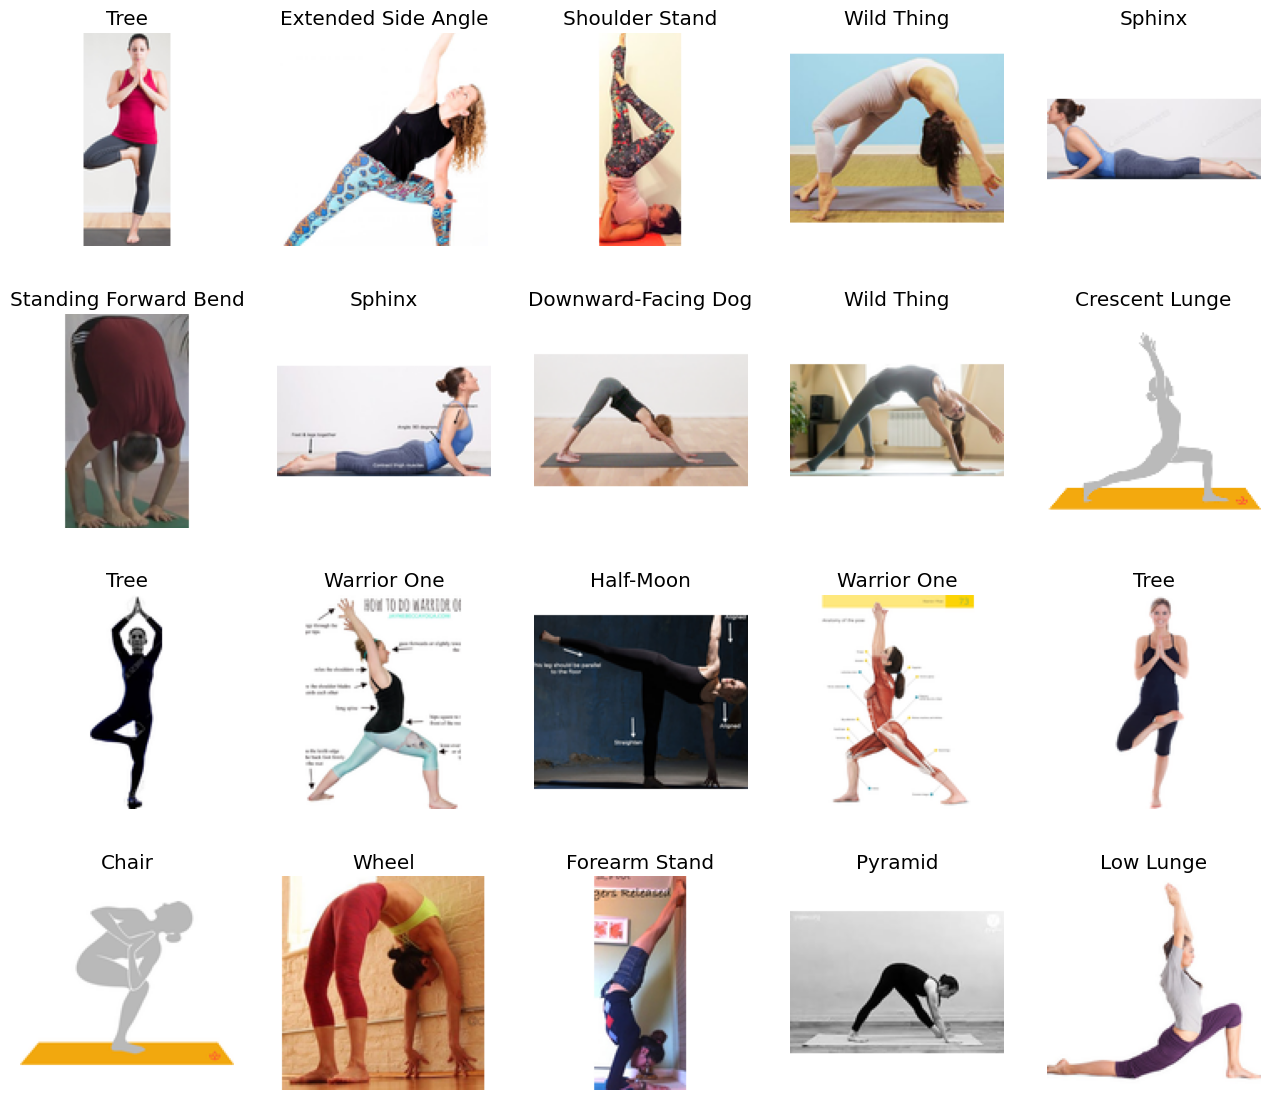

In [9]:
fig = plt.figure(figsize=(16, 14))

samples = np.random.randint(0, len(X), 20)

for i, img_idx in enumerate(samples):
    fig.add_subplot(4, 5, i + 1)

    plt.imshow(X[img_idx])
    plt.title(labelNames[y[img_idx]])
    plt.axis("off")

plt.show()

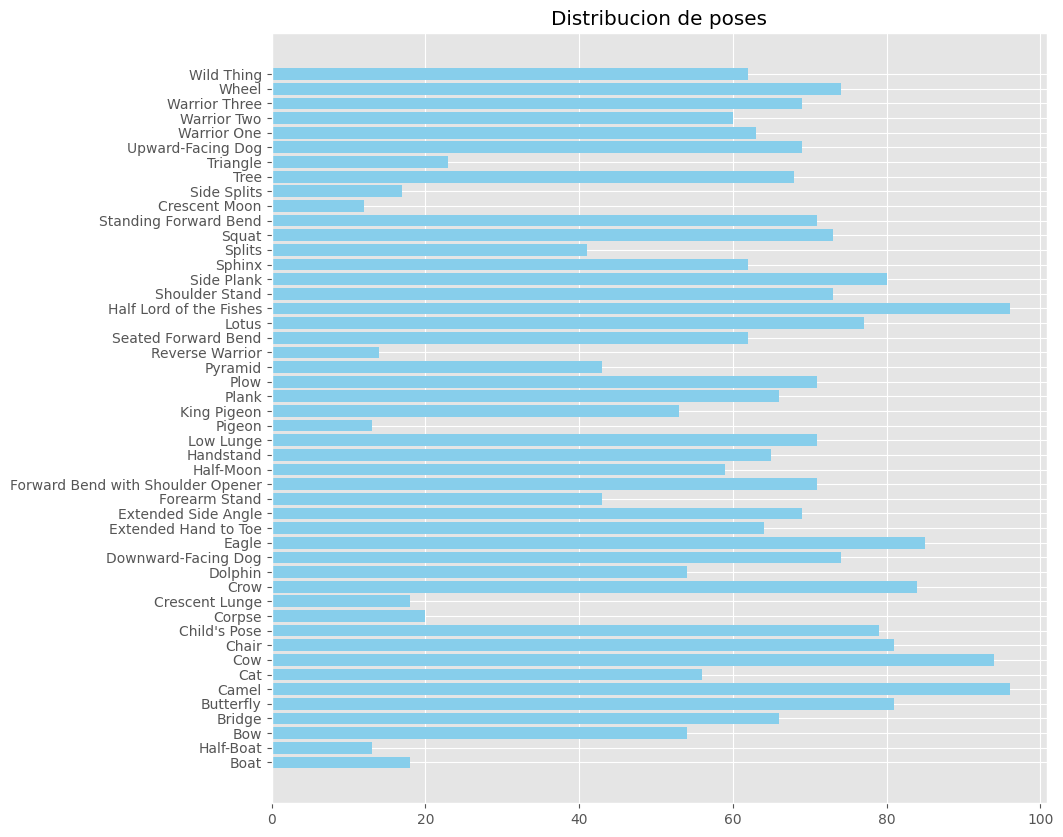

In [10]:
y_counts = np.bincount(y)

plt.figure(figsize=(10, 10))
plt.barh(labelNames.values(), y_counts, color="skyblue")
plt.title("Distribucion de poses")
plt.show()

### 3. Data Augmentation


In [11]:
datagen = K.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    brightness_range=(0.8, 1.2),
)

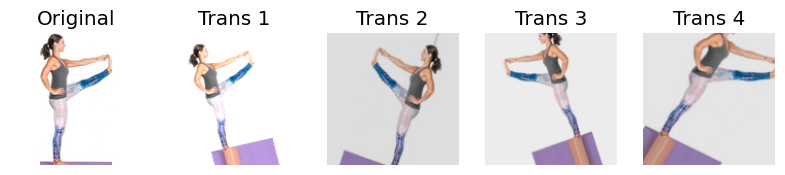

In [16]:
# Obtención random de una imagen del DS
sample = random.randint(0, len(X))
img_orig = X[sample]

fig = plt.figure(figsize=(16, 10))

# Mostrar imagen original
fig.add_subplot(4, 8, 1)
plt.imshow(img_orig)
plt.title("Original")
plt.axis("off")

# Mostrar transformaciones de las imagenes
for n in range(4):
    fig.add_subplot(4, 8, n + 2)
    # generamos nueva imagen usando el DataGenerator
    img = datagen.random_transform(img_orig)
    plt.imshow(img.astype(np.uint8))
    plt.title(f"Trans {n + 1}")
    plt.axis("off")

plt.show()

### 4. Balanceo de clases


In [17]:
# Recorremos todas los labels
for label in np.unique(y):
    X_filtered = X[y == label]
    # calculamos la cantidad de imagenes a generar
    num_augmentations = IMG_COUNT_PER_CLASS - len(X_filtered)

    if num_augmentations > 0:
        print(f"[INFO]: Nuevas {num_augmentations} poses de {labelNames[label]}")
        # ordenamos las imagenes de forma tal que el orden inicial no importe
        img_random_order = np.random.permutation(X_filtered)

        # generamos nuevas imagenes usando el DataGenerator
        X_aug = [
            datagen.random_transform(img_random_order[i % len(X_filtered)]).astype(
                np.uint8
            )
            for i in range(num_augmentations)
        ]

        # agregamos la misma cantidad de labels como imagenes generadas
        y_aug = [label] * num_augmentations

        # agregamos augmentations a X e y
        X = np.append(X, np.array(X_aug), axis=0)
        y = np.append(y, np.array(y_aug), axis=0)

[INFO]: Nuevas 182 poses de Boat
[INFO]: Nuevas 187 poses de Half-Boat
[INFO]: Nuevas 146 poses de Bow
[INFO]: Nuevas 134 poses de Bridge
[INFO]: Nuevas 119 poses de Butterfly
[INFO]: Nuevas 104 poses de Camel
[INFO]: Nuevas 144 poses de Cat
[INFO]: Nuevas 106 poses de Cow
[INFO]: Nuevas 119 poses de Chair
[INFO]: Nuevas 121 poses de Child's Pose
[INFO]: Nuevas 180 poses de Corpse
[INFO]: Nuevas 182 poses de Crescent Lunge
[INFO]: Nuevas 116 poses de Crow
[INFO]: Nuevas 146 poses de Dolphin
[INFO]: Nuevas 126 poses de Downward-Facing Dog
[INFO]: Nuevas 115 poses de Eagle
[INFO]: Nuevas 136 poses de Extended Hand to Toe
[INFO]: Nuevas 131 poses de Extended Side Angle
[INFO]: Nuevas 157 poses de Forearm Stand
[INFO]: Nuevas 129 poses de Forward Bend with Shoulder Opener
[INFO]: Nuevas 141 poses de Half-Moon
[INFO]: Nuevas 135 poses de Handstand
[INFO]: Nuevas 129 poses de Low Lunge
[INFO]: Nuevas 187 poses de Pigeon
[INFO]: Nuevas 147 poses de King Pigeon
[INFO]: Nuevas 134 poses de Plan

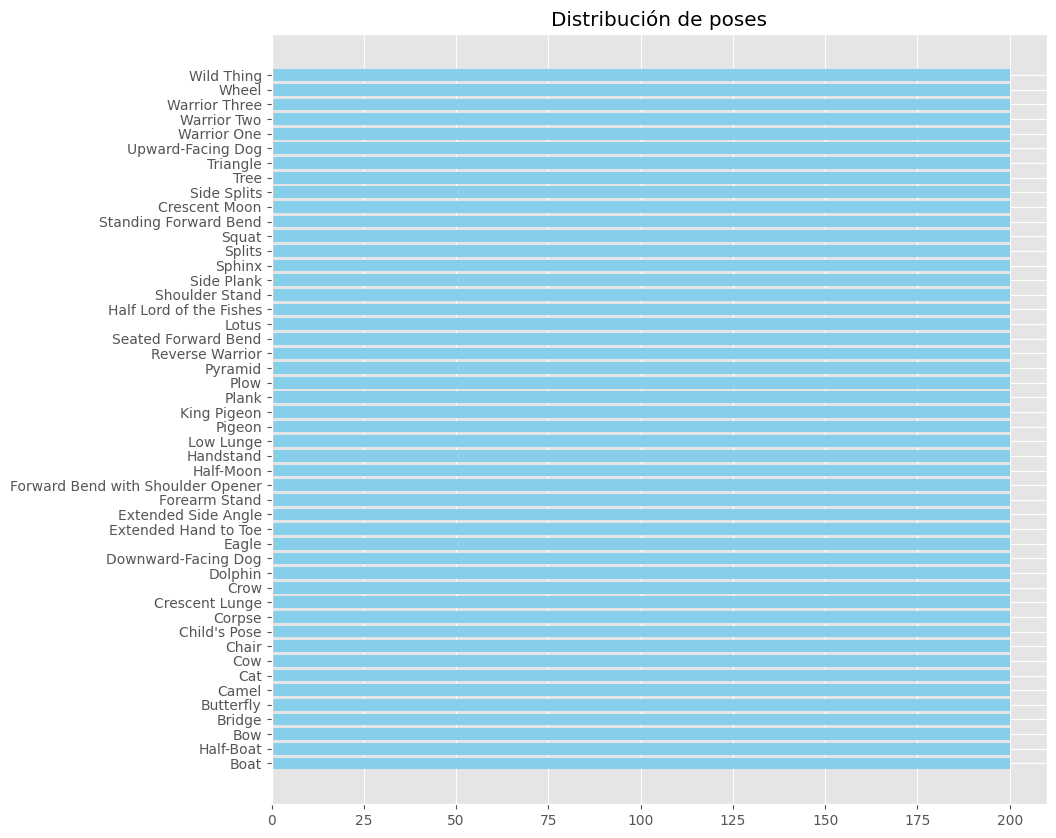

In [19]:
y_counts = np.bincount(y)

plt.figure(figsize=(10, 10))
plt.barh(labelNames.values(), y_counts, color="skyblue")
plt.title("Distribución de poses")
plt.show()

### 5. Data hold-out


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=RANDOM_SEED,
    stratify=y,
)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)
print("----")
print("Distribución de clases en y_train:", np.bincount(y_train))
print("Distribución de clases en y_test:", np.bincount(y_test))

X_train: (6720, 128, 128, 3) y_train: (6720,)
X_test: (2880, 128, 128, 3) y_test: (2880,)
----
Distribución de clases en y_train: [140 140 140 140 140 140 140 140 140 140 140 140 140 140 140 140 140 140
 140 140 140 140 140 140 140 140 140 140 140 140 140 140 140 140 140 140
 140 140 140 140 140 140 140 140 140 140 140 140]
Distribución de clases en y_test: [60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60
 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60]


### 6. Normalización


In [25]:
from sklearn.preprocessing import LabelBinarizer

# Dado que vamos a utilizar el DataGenerator, no hace falta que apliquemos la normalización de X

# One hot encoding for labels
lb = LabelBinarizer()
y_train_n = lb.fit_transform(y_train)
y_test_n = lb.transform(y_test)

## Estrategia 1 - Entrenar desde cero


In [26]:
# Config for model training
MAX_N_EPOCHS = 300
INITIAL_LR = 1e-3
BATCH_SIZE = 64

# Config for model callbacks
MODEL_NAME = "from-scratch.h5"
MONITOR_VALUE = "val_loss"

EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_MIN_DELTA = 0.001

REDUCE_LR_PATIENCE = 5
MIN_LR = 1e-6
REDUCE_LR_FACTOR = 0.1

In [28]:
input_shape = (IMG_RES, IMG_RES, 3)
n_classes = len(labelNames)


# Función para crear facilmente nuevas capas con normalización
def buildConv2DLayer(n_neurons: int):
    return [
        K.layers.Conv2D(
            n_neurons,
            (3, 3),
            padding="same",
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=K.regularizers.l2(0.01),
            kernel_constraint=K.constraints.max_norm(3.0),
        ),
        K.layers.BatchNormalization(),
        K.layers.MaxPooling2D(pool_size=(2, 2)),
        K.layers.Dropout(0.2),
    ]


layers = [
    # Primera capa
    *buildConv2DLayer(32),
    # Segunda capa
    *buildConv2DLayer(64),
    # Tercera capa
    *buildConv2DLayer(128),
    # Cuarta capa
    *buildConv2DLayer(256),
    # Quinta capa
    *buildConv2DLayer(512),
    # Capa de salida
    K.layers.GlobalAveragePooling2D(),
    K.layers.Dense(n_classes, activation="softmax"),
]

# Capa de entrada
inputs = K.layers.Input(shape=input_shape)

# Composición de las capas de forma funcional
x = inputs
for layer in layers:
    x = layer(x)

# Definición del modelo con entrada y salidas
model = K.models.Model(inputs=inputs, outputs=x)


# Compilar el modelo
print("[INFO]: Compilando el modelo...")
model.compile(
    loss="categorical_crossentropy",
    optimizer=K.optimizers.legacy.Adam(learning_rate=INITIAL_LR),
    metrics=["acc"],
)

model.summary()

[INFO]: Compilando el modelo...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_5 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_6 (Conv2D)         

In [ ]:
# Usar el DataGeneration para training y validation data
train_data = datagen.flow(
    X_train,
    y_train_n,
    batch_size=BATCH_SIZE,
    subset="training",
    seed=RANDOM_SEED,
)

validation_data = datagen.flow(
    X_train,
    y_train_n,
    batch_size=BATCH_SIZE,
    subset="validation",
    seed=RANDOM_SEED,
)

callbacks = [
    # Callback para parar el entrenamiento cuando no converge
    K.callbacks.EarlyStopping(
        monitor=MONITOR_VALUE,
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        min_delta=EARLY_STOPPING_MIN_DELTA,
    ),
    # Callback para bajar el Learning rate cuando ya no converge
    K.callbacks.ReduceLROnPlateau(
        monitor=MONITOR_VALUE,
        factor=REDUCE_LR_FACTOR,
        patience=REDUCE_LR_PATIENCE,
        min_lr=MIN_LR,
    ),
    # Callback para guardar Checkpoint del modelo
    K.callbacks.ModelCheckpoint(
        MODEL_NAME,
        monitor=MONITOR_VALUE,
        save_best_only=True,
        save_weights_only=True,
    ),
]

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=MAX_N_EPOCHS,
    callbacks=callbacks,
)

In [ ]:
from sklearn.metrics import classification_report

# X_test no tuvo normalizacion
X_test_n = X_test / 255

print("[INFO]: Evaluando el modelo...")
predictions = model.predict(X_test_n, batch_size=BATCH_SIZE)

print(
    classification_report(
        y_test,
        predictions.argmax(axis=1),
        target_names=labelNames.values(),
    )
)

[INFO]: Evaluando el modelo...
45/45 [==============================] - 1s 18ms/step
                                   precision    recall  f1-score   support

                             Boat       0.98      1.00      0.99        60
                        Half-Boat       0.98      1.00      0.99        60
                              Bow       0.97      0.98      0.98        60
                           Bridge       1.00      0.97      0.98        60
                        Butterfly       0.93      0.85      0.89        60
                            Camel       0.95      0.93      0.94        60
                              Cat       0.84      0.80      0.82        60
                              Cow       0.87      0.87      0.87        60
                            Chair       0.93      0.92      0.92        60
                     Child's Pose       0.96      0.90      0.93        60
                           Corpse       1.00      1.00      1.00        60
              

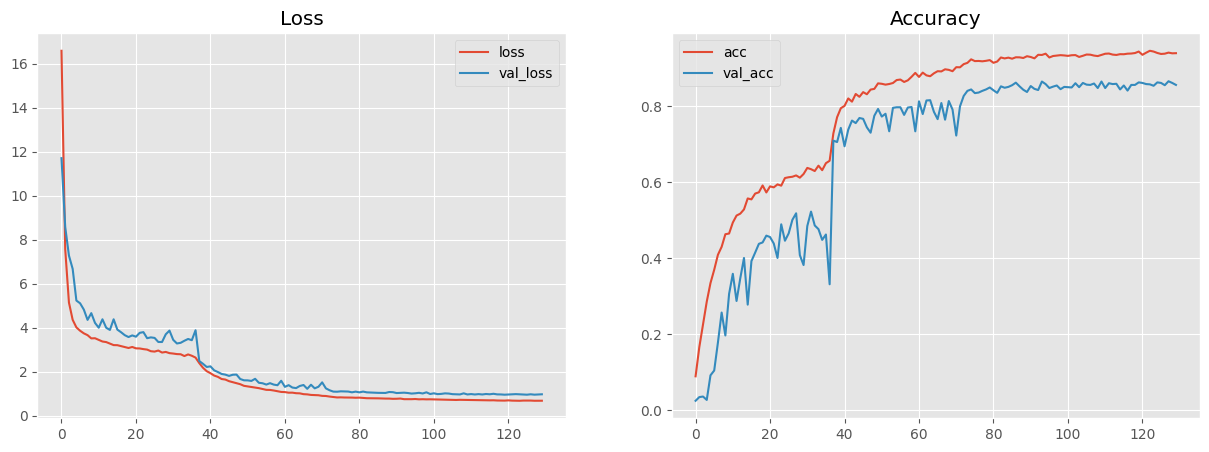

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(H.history)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot 1: Loss and Validation Loss on the first subplot
history_df.loc[:, ["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Loss")

# Plot 2: Accuracy and Validation Accuracy on the second subplot
history_df.loc[:, ["acc", "val_acc"]].plot(ax=axs[1])
axs[1].set_title("Accuracy")

plt.show()

## Estrategia 2 - Red pre-entrenada


### VGG16 - Transfer Learning


In [33]:
# Config para el entrenamiento del modelo
MAX_N_EPOCHS = 300
INITIAL_LR = 1e-3
BATCH_SIZE = 64

# Config para las callbacks
MODEL_NAME = "vgg16-tl.h5"
MONITOR_VALUE = "val_loss"

EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_MIN_DELTA = 0.001

REDUCE_LR_PATIENCE = 5
MIN_LR = 1e-6
REDUCE_LR_FACTOR = 0.1

In [55]:
datagen = K.preprocessing.image.ImageDataGenerator(
    preprocessing_function=K.applications.vgg16.preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    brightness_range=(0.8, 1.2),
)

In [ ]:
input_shape = (IMG_RES, IMG_RES, 3)

# Carga del modelo base
base_model = K.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape,
)

# Modo transfer-learning
for layer in base_model.layers:
    layer.trainable = False


model = K.models.Sequential(
    [
        K.layers.Input(shape=input_shape),
        # Agregar el modelo base
        base_model,
        K.layers.GlobalAveragePooling2D(),
        # Capa Densa
        K.layers.Dense(128, activation="relu"),
        K.layers.BatchNormalization(),
        K.layers.Dropout(0.1),
        # Capa de salida
        K.layers.Dense(len(labelNames), activation="softmax"),
    ]
)

print("[INFO]: Compilando el modelo...")
model.compile(
    loss="categorical_crossentropy",
    optimizer=K.optimizers.legacy.Adam(learning_rate=INITIAL_LR),
    metrics=["acc"],
)

model.summary()

[INFO]: Compilando el modelo...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_4  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_12 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_7 (Dense)      

In [ ]:
train_data = datagen.flow(
    X_train,
    y_train_n,
    batch_size=BATCH_SIZE,
    subset="training",
    seed=RANDOM_SEED,
)

validation_data = datagen.flow(
    X_train,
    y_train_n,
    batch_size=BATCH_SIZE,
    subset="validation",
    seed=RANDOM_SEED,
)

callbacks = [
    K.callbacks.EarlyStopping(
        monitor=MONITOR_VALUE,
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        min_delta=EARLY_STOPPING_MIN_DELTA,
    ),
    K.callbacks.ReduceLROnPlateau(
        monitor=MONITOR_VALUE,
        factor=REDUCE_LR_FACTOR,
        patience=REDUCE_LR_PATIENCE,
        min_lr=MIN_LR,
    ),
    K.callbacks.ModelCheckpoint(
        MODEL_NAME,
        monitor=MONITOR_VALUE,
        save_best_only=True,
        save_weights_only=True,
    ),
]

print("[INFO]: Entrenando la red...")
H = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=MAX_N_EPOCHS,
    callbacks=callbacks,
)

In [ ]:
from sklearn.metrics import classification_report

# X_test no tuvo normalizacion
X_test_n = K.applications.efficientnet.preprocess_input(X_test)

print("[INFO]: Evaluando el modelo...")
predictions = model.predict(X_test_n, batch_size=BATCH_SIZE)

print(
    classification_report(
        y_test,
        predictions.argmax(axis=1),
        target_names=labelNames.values(),
    )
)

[INFO]: Evaluando el modelo...
45/45 [==============================] - 29s 651ms/step
                                   precision    recall  f1-score   support

                             Boat       0.98      0.98      0.98        60
                        Half-Boat       0.97      1.00      0.98        60
                              Bow       0.90      0.88      0.89        60
                           Bridge       0.89      0.93      0.91        60
                        Butterfly       0.79      0.75      0.77        60
                            Camel       0.85      0.87      0.86        60
                              Cat       0.73      0.77      0.75        60
                              Cow       0.79      0.75      0.77        60
                            Chair       0.92      0.97      0.94        60
                     Child's Pose       0.85      0.83      0.84        60
                           Corpse       0.98      1.00      0.99        60
            

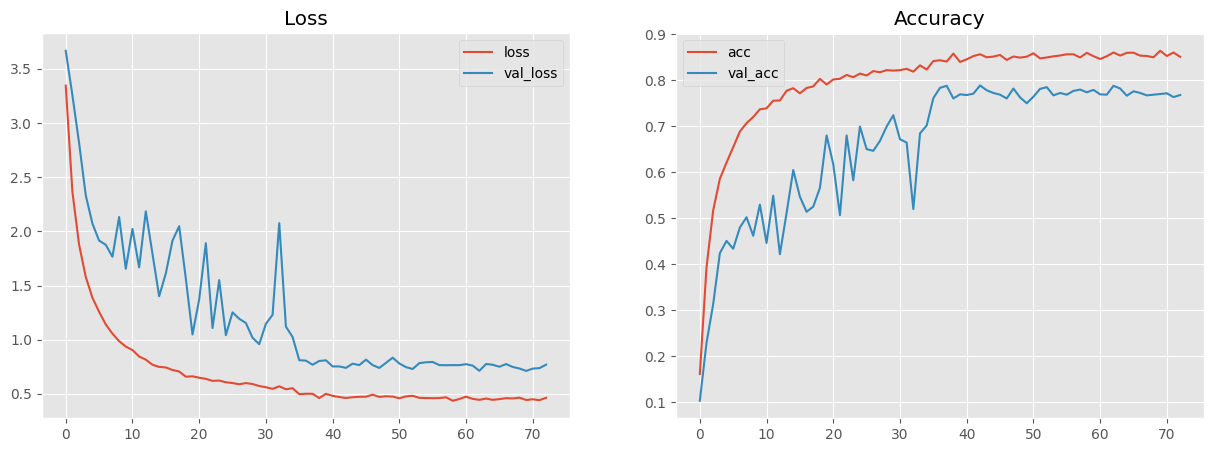

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(H.history)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot 1: Loss and Validation Loss on the first subplot
history_df.loc[:, ["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Loss")

# Plot 2: Accuracy and Validation Accuracy on the second subplot
history_df.loc[:, ["acc", "val_acc"]].plot(ax=axs[1])
axs[1].set_title("Accuracy")

plt.show()

### VGG16 - Fine tuning


In [35]:
# Config for model training
MAX_N_EPOCHS = 300
INITIAL_LR = 1e-3
BATCH_SIZE = 64

# Config for model callbacks
MODEL_NAME = "vgg16-ft.h5"
MONITOR_VALUE = "val_loss"

EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_MIN_DELTA = 0.001

REDUCE_LR_PATIENCE = 5
MIN_LR = 1e-6
REDUCE_LR_FACTOR = 0.1

In [ ]:
datagen = K.preprocessing.image.ImageDataGenerator(
    preprocessing_function=K.applications.vgg16.preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    brightness_range=(0.8, 1.2),
)

In [54]:
input_shape = (IMG_RES, IMG_RES, 3)

# Carga del modelo base
base_model = K.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape,
)

# Unfreeze últimas 4 capas
unfreeze_last_n_layers = 4
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= len(base_model.layers) - unfreeze_last_n_layers

# Definición de capas
model = K.models.Sequential(
    [
        K.layers.Input(shape=input_shape),
        # Agregar el modelo base
        base_model,
        K.layers.GlobalAveragePooling2D(),
        # Capa densa
        K.layers.Dense(128, activation="relu"),
        K.layers.BatchNormalization(),
        K.layers.Dropout(0.3),
        # Capa de salida
        K.layers.Dense(len(labelNames), activation="softmax"),
    ]
)

print("[INFO]: Compilando el modelo...")
model.compile(
    loss="categorical_crossentropy",
    optimizer=K.optimizers.legacy.Adam(learning_rate=INITIAL_LR),
    metrics=["acc"],
)

model.summary()

[INFO]: Compilando el modelo...
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 dense_44 (Dense)            (None, 128)               65664     
                                                                 
 batch_normalization_31 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_31 (Dropout)        (None, 128)               0         
                                                                 
 dense_45 (Dense)    

In [ ]:
train_data = datagen.flow(
    X_train,
    y_train_n,
    batch_size=BATCH_SIZE,
    subset="training",
    seed=RANDOM_SEED,
)

validation_data = datagen.flow(
    X_train,
    y_train_n,
    batch_size=BATCH_SIZE,
    subset="validation",
    seed=RANDOM_SEED,
)

callbacks = [
    K.callbacks.EarlyStopping(
        monitor=MONITOR_VALUE,
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        min_delta=EARLY_STOPPING_MIN_DELTA,
    ),
    K.callbacks.ReduceLROnPlateau(
        monitor=MONITOR_VALUE,
        factor=REDUCE_LR_FACTOR,
        patience=REDUCE_LR_PATIENCE,
        min_lr=MIN_LR,
    ),
    K.callbacks.ModelCheckpoint(
        MODEL_NAME,
        monitor=MONITOR_VALUE,
        save_best_only=True,
        save_weights_only=True,
    ),
]

print("[INFO]: Entrenando la red...")
H = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=MAX_N_EPOCHS,
    callbacks=callbacks,
)

In [ ]:
from sklearn.metrics import classification_report

# X_test no tuvo normalización
X_test_n = K.applications.vgg16.preprocess_input(X_test)

print("[INFO]: Evaluando el modelo...")
predictions = model.predict(X_test_n, batch_size=BATCH_SIZE)

print(
    classification_report(
        y_test,
        predictions.argmax(axis=1),
        target_names=labelNames.values(),
    )
)

[INFO]: Evaluando el modelo...
30/30 [==============================] - 5s 136ms/step
                                   precision    recall  f1-score   support

                             Boat       1.00      1.00      1.00        40
                        Half-Boat       1.00      1.00      1.00        40
                              Bow       0.93      1.00      0.96        40
                           Bridge       1.00      1.00      1.00        40
                        Butterfly       0.95      0.95      0.95        40
                            Camel       1.00      1.00      1.00        40
                              Cat       0.89      0.82      0.86        40
                              Cow       0.84      0.93      0.88        40
                            Chair       1.00      0.97      0.99        40
                     Child's Pose       1.00      0.95      0.97        40
                           Corpse       1.00      1.00      1.00        40
             

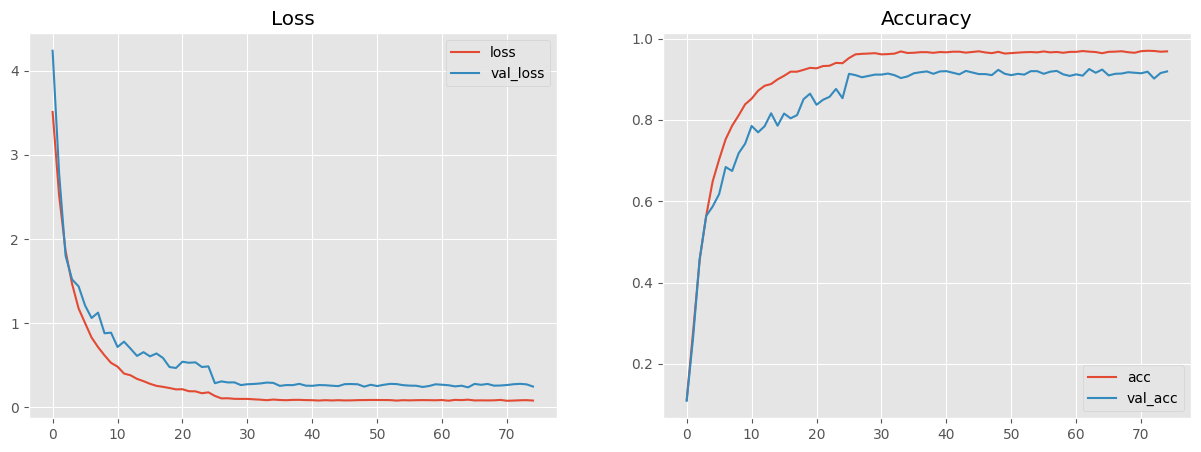

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(H.history)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot 1: Loss and Validation Loss on the first subplot
history_df.loc[:, ["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Loss")

# Plot 2: Accuracy and Validation Accuracy on the second subplot
history_df.loc[:, ["acc", "val_acc"]].plot(ax=axs[1])
axs[1].set_title("Accuracy")

plt.show()

### EfficientNetB1 - Transfer Learning


In [56]:
MODEL_NAME = "effNetB1-tl.h5"
MONITOR_VALUE = "val_loss"

EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_MIN_DELTA = 0.001

REDUCE_LR_PATIENCE = 5
MIN_LR = 1e-6
REDUCE_LR_FACTOR = 0.1

In [ ]:
datagen = K.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=K.applications.efficientnet.preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    brightness_range=(0.8, 1.2),
)

In [ ]:
input_shape = (IMG_RES, IMG_RES, 3)

base_model = K.applications.EfficientNetB1(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape,
)

# Transfer-learning
for layer in base_model.layers:
    layer.trainable = False


# Definición del modelo
model = K.models.Sequential(
    [
        K.layers.Input(shape=input_shape),
        # Agregar modelo base
        base_model,
        K.layers.GlobalAveragePooling2D(),
        # Capa densa
        K.layers.Dense(128, activation="relu"),
        K.layers.BatchNormalization(),
        K.layers.Dropout(0.1),
        # Capa de salida
        K.layers.Dense(len(labelNames), activation="softmax"),
    ]
)

print("[INFO]: Compilando el modelo...")
model.compile(
    loss="categorical_crossentropy",
    optimizer=K.optimizers.legacy.Adam(learning_rate=INITIAL_LR),
    metrics=["acc"],
)

model.summary()

[INFO]: Compilando el modelo...
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional  (None, 4, 4, 1280)        6575239   
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
 4 (GlobalAveragePooling2D)                                      
                                                                 
 dense_46 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_32 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_32 (Dropout)        (None, 128)               0         
                     

In [ ]:
train_data = datagen.flow(
    X_train,
    y_train_n,
    batch_size=BATCH_SIZE,
    subset="training",
    seed=RANDOM_SEED,
)

validation_data = datagen.flow(
    X_train,
    y_train_n,
    batch_size=BATCH_SIZE,
    subset="validation",
    seed=RANDOM_SEED,
)

callbacks = [
    K.callbacks.EarlyStopping(
        monitor=MONITOR_VALUE,
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        min_delta=EARLY_STOPPING_MIN_DELTA,
    ),
    K.callbacks.ReduceLROnPlateau(
        monitor=MONITOR_VALUE,
        factor=REDUCE_LR_FACTOR,
        patience=REDUCE_LR_PATIENCE,
        min_lr=MIN_LR,
    ),
    K.callbacks.ModelCheckpoint(
        MODEL_NAME,
        monitor=MONITOR_VALUE,
        save_best_only=True,
        save_weights_only=True,
    ),
]

print("[INFO]: Entrenando la red...")
H = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=MAX_N_EPOCHS,
    callbacks=callbacks,
)

In [ ]:
from sklearn.metrics import classification_report

# X_test no tuvo normalizacion
X_test_n = K.applications.efficientnet.preprocess_input(X_test)

print("[INFO]: Evaluando el modelo...")
predictions = model.predict(X_test_n, batch_size=BATCH_SIZE)

print(
    classification_report(
        y_test,
        predictions.argmax(axis=1),
        target_names=labelNames.values(),
    )
)

[INFO]: Evaluando el modelo...
45/45 [==============================] - 4s 80ms/step
                                   precision    recall  f1-score   support

                             Boat       0.97      1.00      0.98        60
                        Half-Boat       0.95      1.00      0.98        60
                              Bow       0.92      0.93      0.93        60
                           Bridge       0.90      0.92      0.91        60
                        Butterfly       0.96      0.80      0.87        60
                            Camel       0.85      0.93      0.89        60
                              Cat       0.78      0.72      0.75        60
                              Cow       0.80      0.78      0.79        60
                            Chair       0.90      0.90      0.90        60
                     Child's Pose       0.88      0.95      0.91        60
                           Corpse       1.00      1.00      1.00        60
              

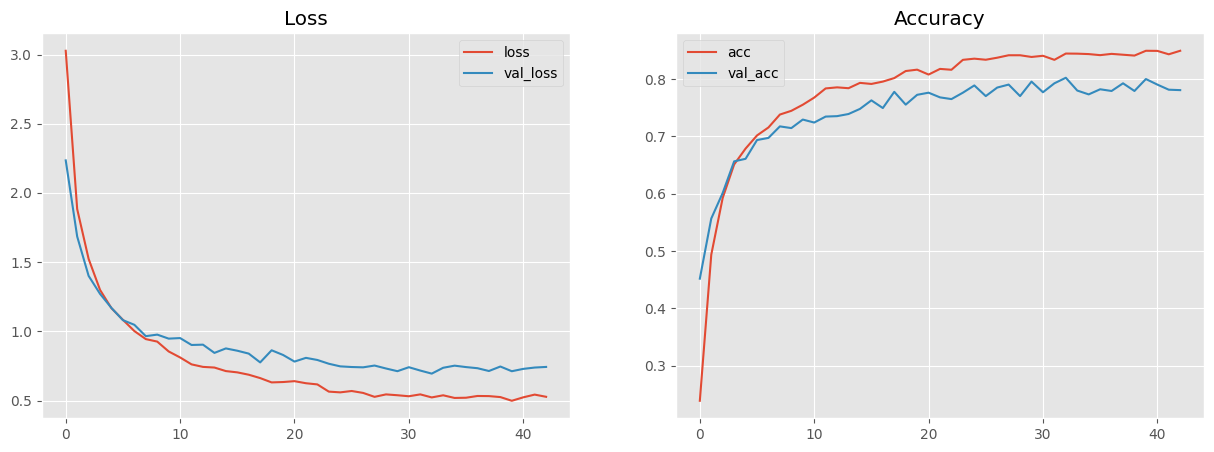

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(H.history)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot 1: Loss and Validation Loss on the first subplot
history_df.loc[:, ["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Loss")

# Plot 2: Accuracy and Validation Accuracy on the second subplot
history_df.loc[:, ["acc", "val_acc"]].plot(ax=axs[1])
axs[1].set_title("Accuracy")

plt.show()

### EfficientNetB1 - Fine tuning


In [ ]:
MODEL_NAME = "effNetB1-tl.h5"
MONITOR_VALUE = "val_loss"

EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_MIN_DELTA = 0.001

REDUCE_LR_PATIENCE = 5
MIN_LR = 1e-6
REDUCE_LR_FACTOR = 0.1

In [ ]:
datagen = K.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=K.applications.efficientnet.preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    brightness_range=(0.8, 1.2),
)

In [58]:
input_shape = (IMG_RES, IMG_RES, 3)

# Carga del modelo pre-entrenado
base_model = K.applications.EfficientNetB1(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape,
)

# Unfreeze ultimas 30 capas
unfreeze_last_n_layers = 30
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= len(base_model.layers) - unfreeze_last_n_layers

# Definición del modelo
model = K.models.Sequential(
    [
        K.layers.Input(shape=input_shape),
        # Add base model
        base_model,
        K.layers.GlobalAveragePooling2D(),
        # Dense layer 1
        K.layers.Dense(128, activation="relu"),
        K.layers.BatchNormalization(),
        K.layers.Dropout(0.3),
        # Output
        K.layers.Dense(len(labelNames), activation="softmax"),
    ]
)

print("[INFO]: Compilando el modelo...")
model.compile(
    loss="categorical_crossentropy",
    optimizer=K.optimizers.legacy.Adam(learning_rate=INITIAL_LR),
    metrics=["acc"],
)

model.summary()

[INFO]: Compilando el modelo...
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional  (None, 4, 4, 1280)        6575239   
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
 5 (GlobalAveragePooling2D)                                      
                                                                 
 dense_48 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_33 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                     

In [ ]:
train_data = datagen.flow(
    X_train,
    y_train_n,
    batch_size=BATCH_SIZE,
    subset="training",
    seed=RANDOM_SEED,
)

validation_data = datagen.flow(
    X_train,
    y_train_n,
    batch_size=BATCH_SIZE,
    subset="validation",
    seed=RANDOM_SEED,
)

callbacks = [
    K.callbacks.EarlyStopping(
        monitor=MONITOR_VALUE,
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        min_delta=EARLY_STOPPING_MIN_DELTA,
    ),
    K.callbacks.ReduceLROnPlateau(
        monitor=MONITOR_VALUE,
        factor=REDUCE_LR_FACTOR,
        patience=REDUCE_LR_PATIENCE,
        min_lr=MIN_LR,
    ),
    K.callbacks.ModelCheckpoint(
        MODEL_NAME,
        monitor=MONITOR_VALUE,
        save_best_only=True,
        save_weights_only=True,
    ),
]

print("[INFO]: Entrenando la red...")
H = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=MAX_N_EPOCHS,
    callbacks=callbacks,
)

In [ ]:
from sklearn.metrics import classification_report

# X_test no tuvo normalizacion
X_test_n = K.applications.efficientnet.preprocess_input(X_test)

print("[INFO]: Evaluando el modelo...")
predictions = model.predict(X_test_n, batch_size=BATCH_SIZE)

print(
    classification_report(
        y_test,
        predictions.argmax(axis=1),
        target_names=labelNames.values(),
    )
)

[INFO]: Evaluando el modelo...
45/45 [==============================] - 5s 117ms/step
                                   precision    recall  f1-score   support

                             Boat       0.98      1.00      0.99        60
                        Half-Boat       0.98      1.00      0.99        60
                              Bow       0.98      0.97      0.97        60
                           Bridge       0.94      0.97      0.95        60
                        Butterfly       0.92      0.93      0.93        60
                            Camel       0.98      0.93      0.96        60
                              Cat       0.92      0.90      0.91        60
                              Cow       0.89      0.92      0.90        60
                            Chair       1.00      0.98      0.99        60
                     Child's Pose       0.98      0.97      0.97        60
                           Corpse       1.00      1.00      1.00        60
             

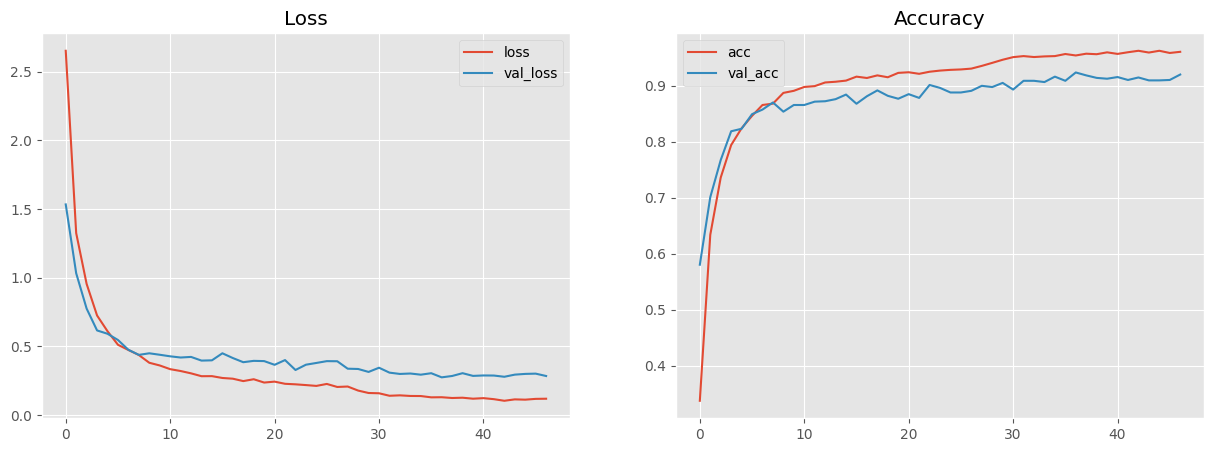

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(H.history)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot 1: Loss and Validation Loss on the first subplot
history_df.loc[:, ["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Loss")

# Plot 2: Accuracy and Validation Accuracy on the second subplot
history_df.loc[:, ["acc", "val_acc"]].plot(ax=axs[1])
axs[1].set_title("Accuracy")

plt.show()

# Análisis y conclusiones


## Análisis y justificación empírica de Modelo from scratch

### 1. Construcción Inicial del Modelo
El desarrollo comenzó con un modelo CNN utilizando la API funcional de Keras. Inicialmente, el modelo tenía dos bloques de capas convolucionales:

* Bloques de Convolución: Cada bloque consistía en capas Conv2D con 32 o 64 filtros, seguidas de BatchNormalization, y una capa de MaxPooling2D para reducir la dimensionalidad. Se aplicaba SpatialDropout2D para mejorar la generalización.
* Pooling Global y Salida: El modelo finalizaba con un GlobalAveragePooling2D, seguido de una capa densa con una función de activación softmax para la clasificación.
* Optimización y Compilación: Se utilizó el optimizador Adam con categorical_crossentropy como la función de pérdida y accuracy como métrica de evaluación.
  
### 2. Mejora Progresiva del Modelo
Se fué realizando varias modificaciones al modelo con el objetivo de mejorar su rendimiento y evitar el sobreajuste, siempre toamando como guía la evolución de las métricas de entrenamiento y validación:

**Cantidad de datos a procesar y pre procesamiento**

Al inicio del proceso, el modelo CNN mostraba un desempeño deficiente. Uno de los principales motivos era la falta de suficientes imágenes de entrenamiento, lo cual resultaba en un sobreajuste temprano y una baja capacidad de generalización. Con un conjunto de datos pequeño, el modelo no tenía suficiente diversidad para aprender características robustas y generalizar correctamente a nuevos ejemplos.

Para abordar este problema, se decidió aplicar un preprocesamiento de las imágenes y técnicas de data augmentation. Esto ayudó a mejorar la cantidad efectiva de datos, introduciendo variedad en el conjunto de entrenamiento y reduciendo el riesgo de sobreajuste.

En cuanto al preprocesameinto de las imágenes, se aplicó lo siguiente:
* Fondo Blanco para Transparencias: Algunas imágenes contenían canales alfa, por lo que se aplicó un fondo blanco para convertirlas en formato RGB, facilitando el procesamiento del modelo.
* Redimensionado Manteniendo la Relación de Aspecto: Dependiendo de la relación entre ancho y altura, la imagen era escalada para adaptarse a las nuevas dimensiones especificadas (img_size), asegurando que la relación de aspecto original se preservara para evitar distorsiones.
* Acolchado (Padding): Una vez escalada, la imagen era centrada en un fondo blanco de las dimensiones requeridas (img_size), de tal forma que se mantenían las proporciones y la imagen se ajustaba sin perder información visual relevante.


Dentro de las técnicas de data augmentation estaban:
* Rotación, Traslación y Zoom: Estos métodos permitieron generar nuevas perspectivas de las imágenes existentes, ayudando al modelo a volverse invariante a rotaciones, traslaciones y cambios de escala.
* Normalización (rescale=1.0 / 255.0): La normalización de los valores de los píxeles entre 0 y 1 ayudó a estabilizar el proceso de entrenamiento y a evitar que los valores grandes afectaran la convergencia del modelo.
* Cizalladura y Zoom: La cizalladura (shear_range=0.1) y el zoom (zoom_range=0.2) ayudaron a variar la geometría de las imágenes, generando perspectivas diferentes y haciendo que el modelo fuese más robusto a estas distorsiones.
Variación de Brillo (brightness_range=(0.8, 1.2)): Esta técnica añadió robustez al modelo frente a cambios en la iluminación, lo cual es crucial para aplicaciones en entornos reales donde las condiciones de luz pueden variar.



**Batch Size y Datos:**

El batch size fue ajustado. Por problemas de memoria del pc con el que se comenzó el desarrollo  se probaron valores  bajos como 4 y 6, luego se aumentó a 32 y 64, y se observó que tamaños de lote más grandes ayudaban a la estabilidad, pero, si el valor era demasiado alto, generaba problemas de overfitting.

**Ajuste del Learning Rate:**

Inicialmente, el learning rate fue establecido en valores que en principio parecian bajos, empezando con 0.001 y ajustándose progresivamente hasta alcanzar 0.0001. A medida que incrementabas el learning rate, observaste mejoras en la velocidad de convergencia del modelo y disminución en la pérdida.
Sin embargo, valores muy altos generaban inestabilidad en la validación, mostrando que había un punto de equilibrio que debía respetarse.

<div style="text-align: center">
<figcaption>LearninRate 0,001</figcaption>
</div>

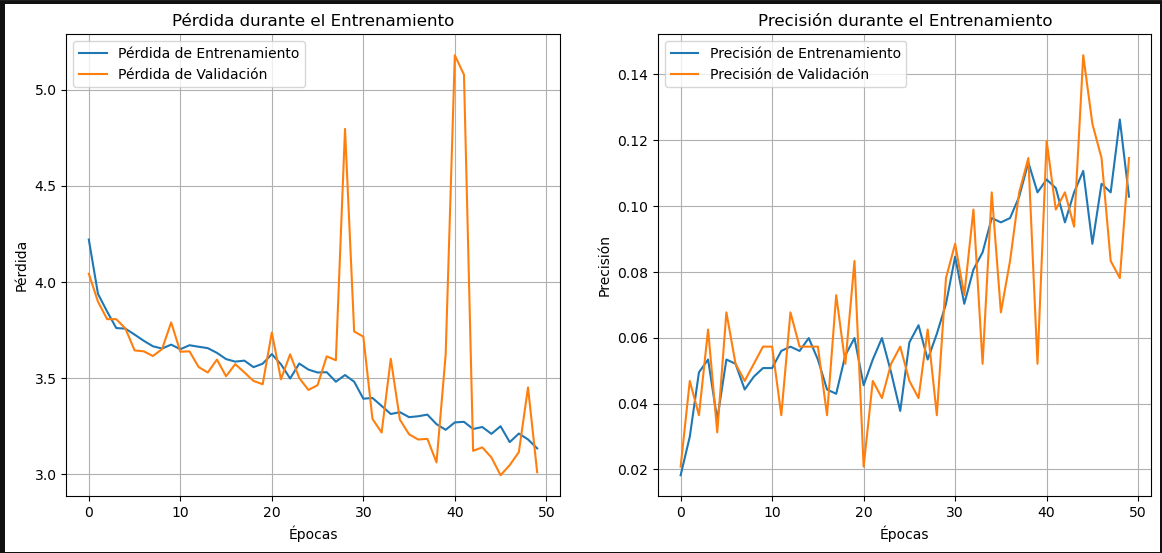


<div style="text-align: center">
<figcaption>LearninRate 0,0001</figcaption>
</div>    

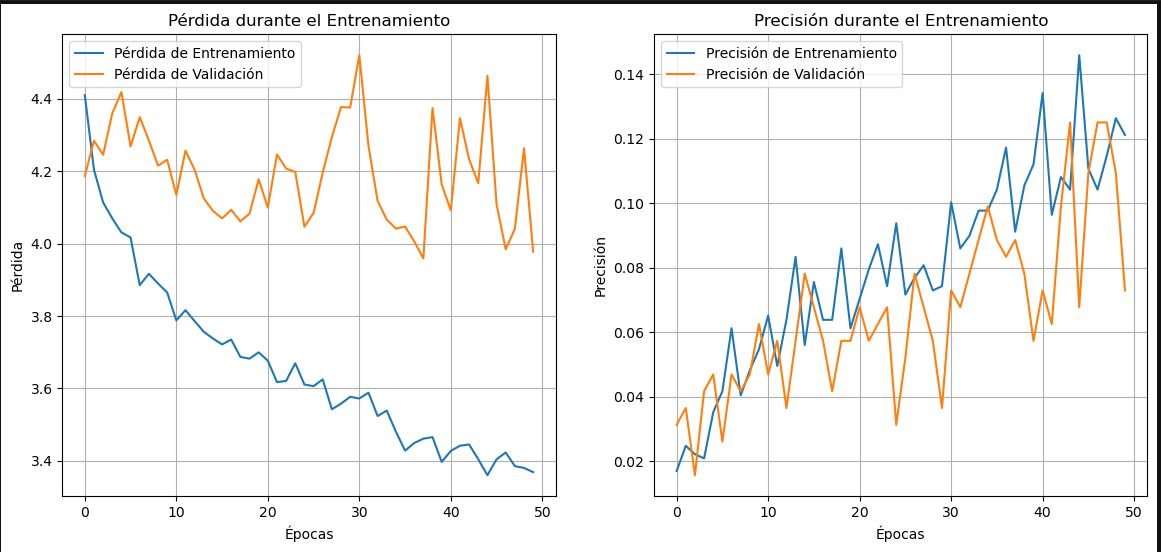


**Aumento de Épocas y Filtros:**

* Épocas: Inicialmente se usó una cantidad moderada de épocas, incrementándola posteriormente a 100 para observar si el modelo continuaba mejorando, se notó que más épocas ayudaban a reducir la pérdida, pero también incrementaban el riesgo de sobreajuste, especialmente si no se ajustaban bien otros parámetros.

<div style="text-align: center">
<figcaption>50 epocs</figcaption>
</div>

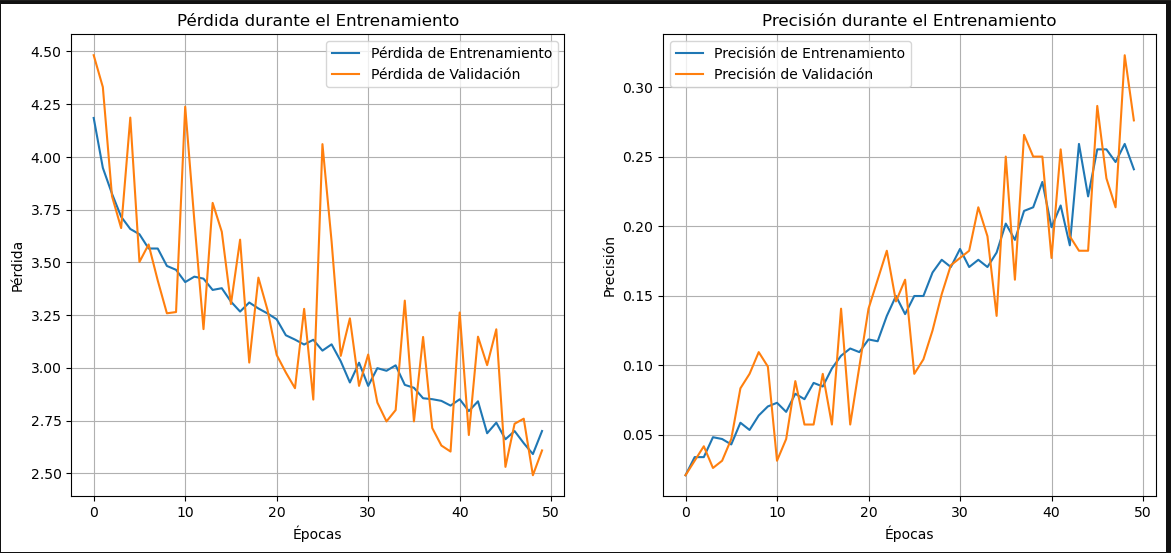

<div style="text-align: center">
<figcaption>100 epocs</figcaption>
</div>

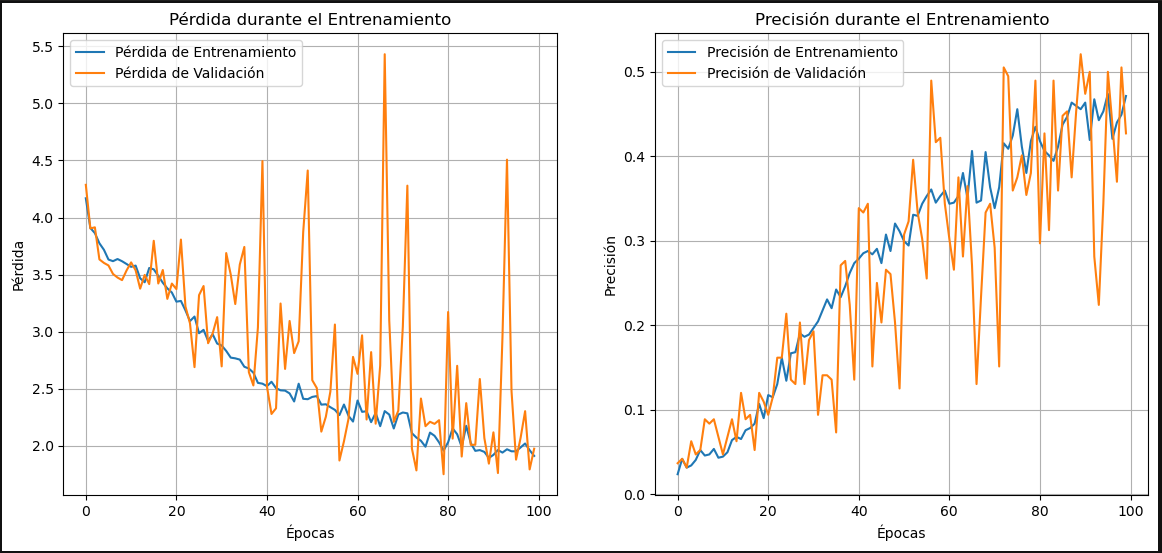

Número de Filtros: Los bloques convolucionales fueron modificados aumentando la cantidad de filtros en cada capa. Llegaste a probar configuraciones con tres bloques de 32, 64, y 128 filtros respectivamente, hasta llegar a modelos más profundos con cinco bloques que tenían 32, 64, 128, 256 y 512 filtros. Las mejoras fueron significativas hasta llegar al modelo actual.

<div style="text-align: center">
<figcaption>Filtros 32,64,128</figcaption>
</div>

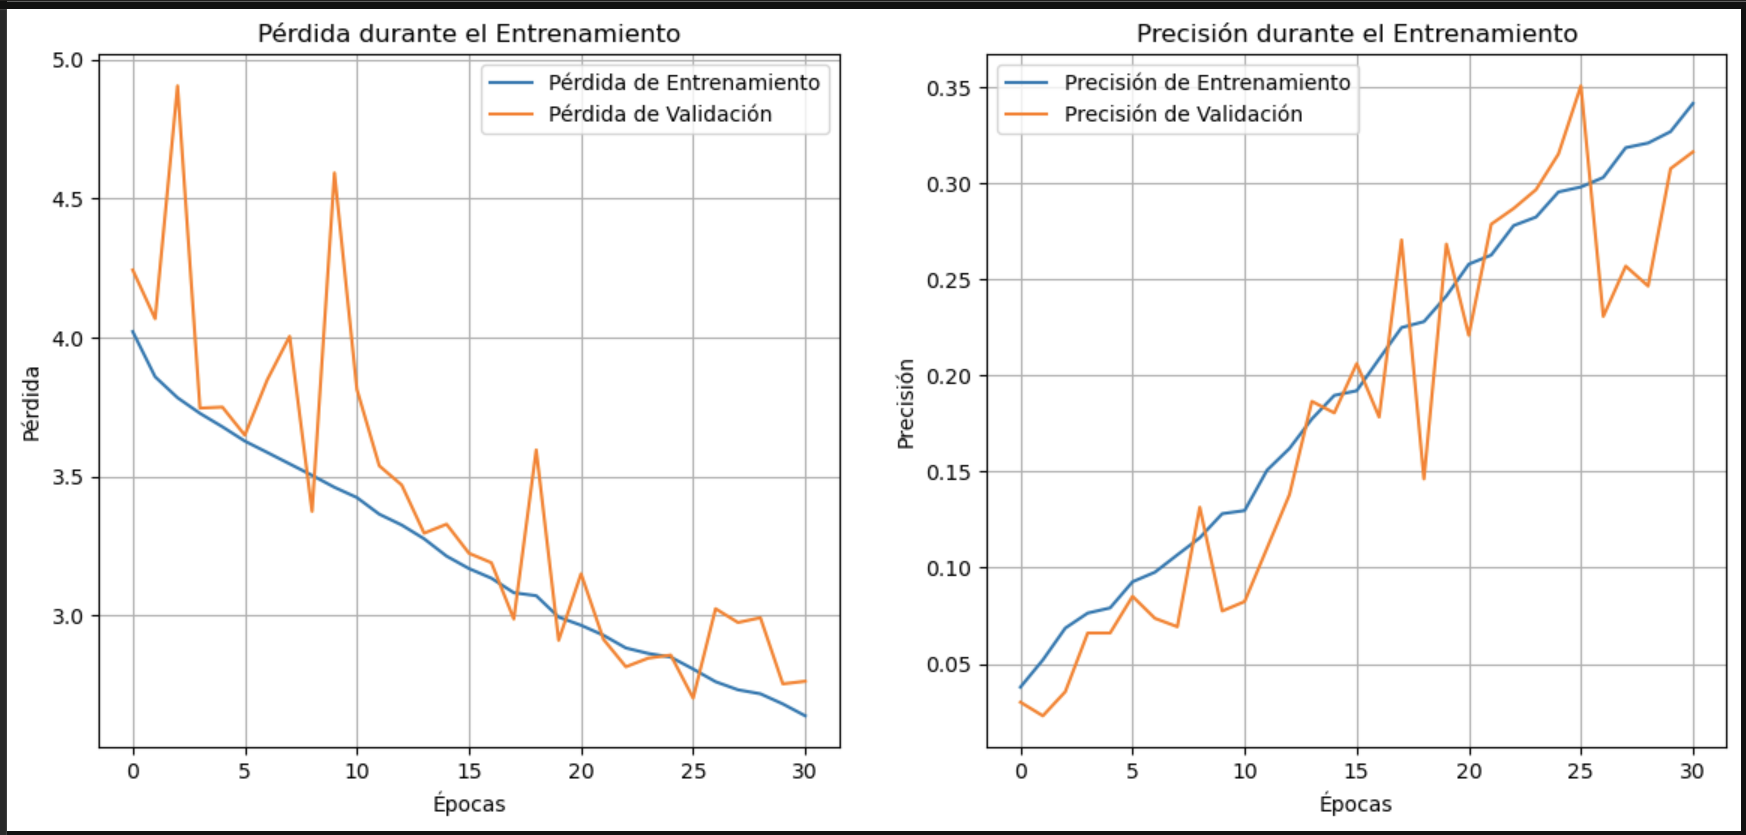

<div style="text-align: center">
<figcaption>Filtros 32,64,128,256,512</figcaption>
</div>

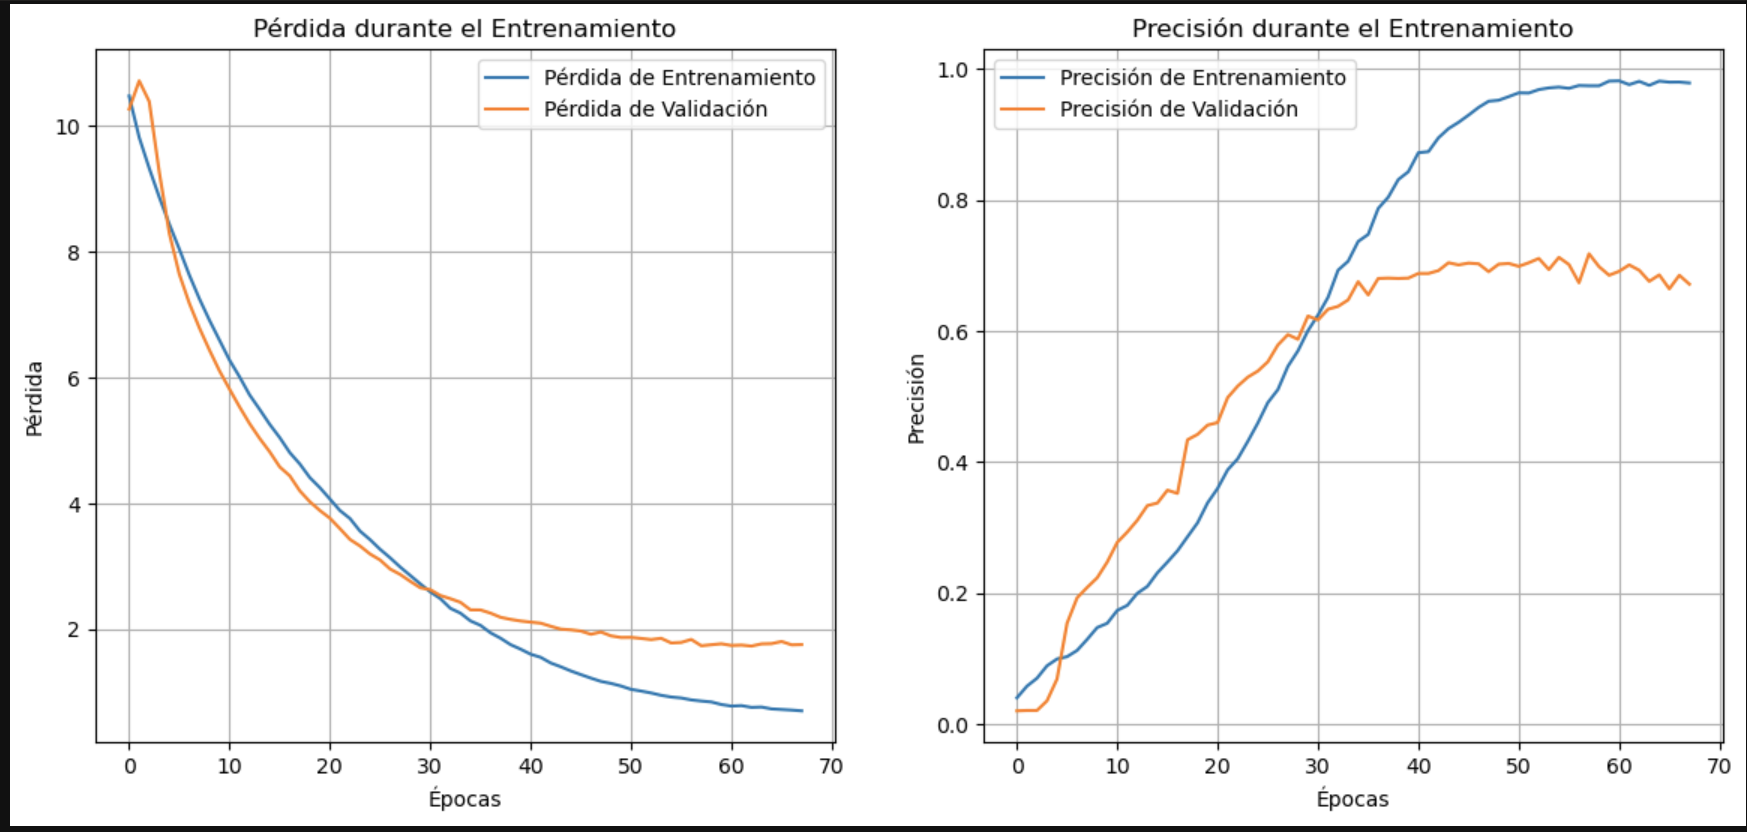

**Regularización y Dropout:**

Se añade luego la regularización l2 con diferentes valores para reducir el sobreajuste.
Aumentaste el valor del dropout a 0.1 y luego a 0.2. El Dropout se mostró eficaz para reducir la inestabilidad en el entrenamiento, aunque en ocasiones podía causar overfitting en la validación.

**Callbacks usados**

Además de los ajustes a la arquitectura y los hiperparámetros, se implementó varios callbacks para mejorar el proceso de entrenamiento:
* Early Stopping: se usó para detener el entrenamiento si el modelo no mejoraba después de un número determinado de épocas (patience). Esto permitió evitar el sobreentrenamiento y restaurar los mejores pesos observados durante el entrenamiento.
* Reduce Learning Rate on Plateau: se usó para disminuir el learning rate si el rendimiento en la métrica de monitoreo dejaba de mejorar, lo cual ayudó a que el modelo convergiera mejor en etapas avanzadas del entrenamiento.
* Model Checkpoint: se usó para guardar el mejor modelo durante el entrenamiento, permitiendo restaurar el estado óptimo del modelo.


Después de unificar todas las mejoras conseguidas y documentarlas, se abandonan los prototipos y se crea el modelo presente en la actividad el cual generó el siguiente resultado: 

<div style="text-align: center">
<figcaption>Modelo final</figcaption>
</div>

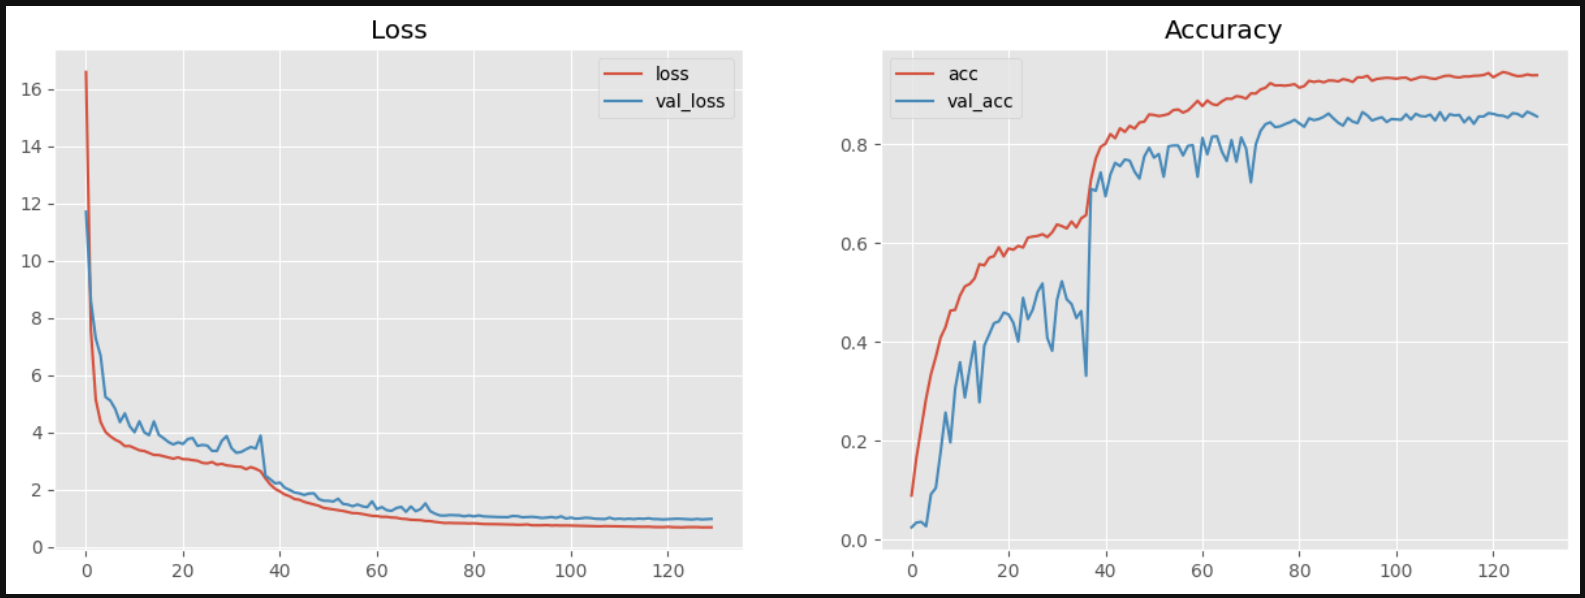




## **Justificación del modelo preentrenado**

Las redes preentrenadas, como VGG16 y EfficientNetB1, tienen grandes ventajas en la clasificación de posturas de yoga. Estas redes, por un lado, pueden captar características visuales complejas a partir de grandes conjuntos de datos sobre los que fueron preentrenadas, como ImageNet. Este conocimiento previo les permite adaptarse mejor a tareas específicas de un nuevo dominio, como el reconocimiento de posturas, con una necesidad mínima o nula de contar con enormes conjuntos de datos.

**VGG16 y EfficientNetB1 en aprendizaje por Transfer Learning**

Reducción del tiempo de entrenamiento: Dado que las capas de la red se congelan excepto las últimas, se mantienen las características generales aprendidas de ImageNet, como bordes, texturas y patrones básicos, lo que facilita la adaptación a un nuevo conjunto de posturas de yoga. Esto permite que el modelo aprenda más rápido, lo que, a su vez, reduce considerablemente el tiempo de cómputo del modelo.

El proceso de limitar el número de parámetros, entrenados del modelo mediante el aprendizaje por Transfer Learning, minimiza el riesgo de sobreajuste en conjuntos de datos pequeños o medianos, como los de posturas de yoga, asegurando así una mejor capacidad de generalización del modelo en las muestras de prueba.

Eficiencia de recursos: Al ser un proceso relativamente eficiente en términos de memoria y procesador, no modifica las capas profundas, lo cual ahorra una gran capacidad computacional en comparación con el entrenamiento de una red desde cero, algo factible para hardware con capacidades limitadas.

**VGG16 y EfficientNetB1 con Fine Tuning** 

Para una adaptación específica a las características del conjunto de datos: En esta modalidad, se descongelan las últimas capas de los modelos VGG16 y EfficientNetB1. Esto resulta especialmente beneficioso para conjuntos de datos complejos y muy diversos, como el de las posturas de yoga, que pueden requerir una especialización en los patrones de las capas superiores.

Optimización del rendimiento: El Fine Tuning proporciona flexibilidad para adaptar los parámetros del modelo a las características específicas del conjunto de datos de yoga, lo que aumenta la precisión y el rendimiento del modelo más allá del aprendizaje por Transfer Learning puro.

Gracias a su arquitectura sólida y comprobada, VGG16 y EfficientNetB1 ofrecen una alta precisión en cuanto a la eficiencia computacional. EfficientNetB1, en particular, es un mejor ejemplo en términos de número de parámetros, ya que produce modelos más ligeros y precisos, optimizando así el tiempo de inferencia y el consumo de memoria.


## Resultados Comparativos: Entrenamiento desde Cero vs Redes Pre-entrenadas

1. **Precisión**: Los modelos pre-entrenados alcanzaron una mayor precisión en la clasificación de posturas de yoga en comparación con el modelo entrenado desde cero. Esto se debe a que las redes pre-entrenadas, al estar inicializadas con características generales de grandes conjuntos de datos, lograron capturar detalles importantes sin necesidad de tantos datos específicos.
2. **Generalización**: Los modelos pre-entrenados también mostraron una mejor capacidad de generalización en el conjunto de validación, mientras que el modelo entrenado desde cero fue más propenso al _overfitting_, siendo más sensible a las variaciones en los datos de entrenamiento.
3. **Eficiencia Computacional**: Los modelos pre-entrenados permitieron un entrenamiento más rápido, ya que su punto de partida incluyó patrones previamente aprendidos, mientras que el modelo desde cero requirió más tiempo para alcanzar un rendimiento aceptable.
4. **Tamaño del Modelo**: El modelo entrenado desde cero resultó ser significativamente más pequeño en tamaño que los modelos pre-entrenados. Esto representa una ventaja en aplicaciones con limitaciones de almacenamiento, aunque el menor tamaño viene acompañado de una disminución en precisión y capacidad de generalización.


## Conclusiones

* El uso de redes preentrenadas y la combinación de técnicas de aprendizaje por Transfer Learning y Fine Tuning ofrecen una solución bien equilibrada en términos de rendimiento, capacidad de generalización y eficiencia. Por lo tanto, ambos métodos resultan óptimos en circunstancias en las que entrenar desde cero es demasiado costoso e ineficiente.
* Los modelos pre-entrenados mostraron claras ventajas en precisión, generalización y tiempo de entrenamiento. Sin embargo, el modelo desde cero destacó por su tamaño reducido, lo que puede ser beneficioso en entornos con restricciones de almacenamiento, aunque con una leve disminución en el rendimiento global.
* Existe una importancia crucial en tener al alcance una cantidad de datos suficiente para poder entrenar el modelo CNN desde cero, una poca cantidad produce problemas de sobre entrenamiento y poca eficacia en suys resultados. Adicionalemten los datos de entrada pueden requerir pre procesamiento para ajsutarlos a las necesidades del entrenamiento, como puede ser el tamaño, eliminar canal alfa y otras modificaciones que ayudan a mejorar su procesamiento en el entrenamiento. 
* Cuando existe inestabilidad en los valores de accuracy y loss, se puede mejorar ajustando los valores de learning rate, así como SpatialDropout2D y Dropout


## Demo técnica
Como tarea extra en el trabajo realizado, decidimos crear una pequeña demo técnica del modelo VGG16 con fine tuning a modo que sea accesible a todas las personas que quieran probar la eficacia del mismo.

El sitio se encuentra disponible en la siguiente URL: [yoga-classification-web-demo.streamlit.app](https://yoga-classification-web-demo.streamlit.app/)

Para mas información también se puede encontrar el código de la demo dentro de [Github](https://github.com/EmaSuriano/yoga-classification-web-app-python-streamlit).
